# Nanodegree Engenheiro de Machine Learning
## Projeto final – Prevendo salários de vagas de emprego
<br />
**Leonardo Mizoguti – 28/04/2018**


### 1ª etapa: Análise, limpeza e normalização dos dados

**Carregamento dos dados**

Antes de mais nada, precisamos carregar os dados do CSV, desconsiderar algumas colunas que não serão usadas no modelo, como por exemplo país (pois todas as vagas estão baseadas nos Estados Unidos), data de criação, URL, etc, e remover eventuais entradas duplicadas.

In [1]:
# Importar as bibliotecas necessárias
%matplotlib inline
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer

from gensim.models import KeyedVectors
from scipy.sparse import csr_matrix, hstack

# Configurar pandas para exibir até 1000 caracteres de cada coluna e não limitar linhas exibidas
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_rows', None)

# Carregar os dados do CSV original
data = pd.read_csv('./monster_com-job_sample.csv')

# Desconsiderar colunas não úteis para o modelo
columns_to_drop = ['country', 'country_code', 'date_added', 'has_expired', 'job_board', 'page_url', 'uniq_id']
data.drop(columns_to_drop, axis = 1, inplace = True)

# Remover eventuais entradas duplicadas
data = data.drop_duplicates()

# Verificar se dados foram carregados corretamente e amostrar algumas vagas
print "Foram carregados {} vagas com {} atributos cada.".format(*data.shape)
data.sample(n = 3)

Foram carregados 20831 vagas com 7 atributos cada.


,job_description,job_title,job_type,location,organization,salary,sector
2721,"Dreaming of a health care career? As a National Guard Health Care Specialist, you will address the health care needs of civilians after natural disasters or civil emergencies. You will also be the first line of defense against injuries and illnesses suffered by our Soldiers through the administration of immediate emergency care and ongoing care and support. After extensive Army medical training, you will be prepared to provide fellow Soldiers with first-rate health care in any setting, from field hospitals to state-of-the-art facilities. Your training will also prepare you for a rewarding civilian career in the health care field.Earn while you learn Get paid to learn! Join the Guard and you will learn valuable job skills while earning a regular paycheck and qualifying for tuition assistance.Job training requires 10 weeks of Basic Training, where you'll learn fundamental Soldiering skills, and seven to 52 weeks of Advanced Individual Training (AIT), which includes practice in patien...",Health Care Specialist Job in El Campo body { margin:px; overflow: visible !important; } #ejb_header { color: #; font-family: Verdana,NaN,El Campo 77437,NaN,NaN,General/Other: Medical/Health
4978,"Position Summary Craft Beer Salesmen at Giant Eagle will create point of difference from our competition by enhancing the customer shopping experience by offering recommendations for beer, food, and entertainment. Our well-trained, knowledgeable Craft Beer Salesmen will help develop and enforce Giant Eagle¿s Passion for Food. Job Responsibilities Assist customers with beer purchases by providing knowledgeable recommendations and suggestions. Educate customers on beer consumption and food pairing. Develop and execute merchandising programs as set out by the strategic business plans regarding the B/W/L Businesses to maintain and improve sales and gross profit, and provide feedback on the effectiveness of the business plans. Review, analyze, and accountability for store B/W/L financial reports, customer satisfaction index, and communicate ideas for improvement to the Store Manager. Monitor stores adherence and personally adhere to company and Ohio state laws, policies, and procedures....",Beer Stock Clerk,Full Time Employee,"Columbus, OH",Food and Beverage Production,NaN,Marketing/Product
17266,"Science Teacher America CAN Dallas, TXAmerica CAN Has multiple vacancies in various Dallas campuses for the following position: High School Science Teacher Bachelor's degree in any field Must have valid Texas Educator Certificate in Science Mail Resumes to Pamela Carroll Chief Human Resources Officer American CAN 325 W. 12th Street Dallas, TX 75208 The Dallas Morning News - 03/20/2016",Science Teacher Job in Dallas,Full Time,"Dallas, TX 75208",Other/Not Classified,NaN,NaN


**Primeira análise de salários**

A informação de salário é essencial para a concepção do modelo de regressão. Precisamos fazer uma primeira análise para remover quaisquer entradas que não possuam indicações de salário. Além disso, precisamos analisar como os salários são indicados e normalizá-los em valores numéricos.

In [2]:
# Selecionar vagas com alguma indicação de salário
salaries = data[pd.notnull(data['salary'])]['salary']

# Selecionar indicações numéricas e não numéricas de salário
numeric_salaries = salaries[salaries.str.match('.*\d.*')]
non_numeric_salaries = salaries[~salaries.str.match('.*\d.*')]

# Selecionar indicações de salário *padronizadas* (i.e. no formato /[\d,]+\.\d{2}/)
currency_salaries = numeric_salaries[numeric_salaries.str.match('.*[\d,]+\.\d{2}.*')]

# Selecionar indicações numéricas de salário *não padronizadas* 
non_currency_salaries = numeric_salaries[~numeric_salaries.str.match('.*[\d,]+\.\d{2}.*')]

# Imprimir resultados
print "Total de vagas com indicação salarial numérica: {}\n".format(numeric_salaries.shape[0])
print "Total de vagas com indicação salarial numérica padronizada: {}\n".format(currency_salaries.shape[0])
print "Total de vagas com indicação salarial numérica não padronizada: {}\n".format(non_currency_salaries.shape[0])

print "--- Exemplos de valores não úteis ---\n"
print non_numeric_salaries.sample(n = 10)

print "\n"

print "--- Exemplo de valores padronizados ---\n"
print currency_salaries.sample(n = 10)

print "\n"

print "--- Exemplo de valores numéricos não padronizados (não necessariamente úteis) ---\n"
print non_currency_salaries.sample(n = 10)

Total de vagas com indicação salarial numérica: 2946

Total de vagas com indicação salarial numérica padronizada: 2904

Total de vagas com indicação salarial numérica não padronizada: 42

--- Exemplos de valores não úteis ---

10023                                    Excellent salary and bonus program
5977                                                    Based on experience
5542                                                  Based upon experience
13729                                   Competitive salary, benefits, bonus
19638                                           Comensurate with experience
9278                                                TBD BASED ON EXPERIENCE
13504    Benefits include health insurance, dental, vision, vacation, bonus
9425                                 Hourly wages will depend on experience
4119                                    Salary commensurate with experience
10209                                            Salary based on experience
Name: salary,

**Padronização de valores numéricos não padronizados de salário**

Vamos analisar as indicações numéricas de salário não padronizadas e padronizá-las ao formato `/[\d,]+\.\d{2}/` (e.g. 12.00; 150,000.00) quando possível, caso contrário vamos desconsiderá-las.

In [3]:
# Listar todas as indicações numéricas não padronizadas
non_currency_salaries.value_counts()

W-2, Weekly Paycheck, Great Compensation Package and Incentives                                                                                                     10
Salary, Commissions, Bonuses, Health Insurance, 401K with matching, Profit Sharing, AFLAC                                                                            1
Full medical, dental, vision coverage; 401K, Life Insurance policy                                                                                                   1
401K, Medical, Dental                                                                                                                                                1
bonus, 401K matching, medical, vacation                                                                                                                              1
Hourly Rate and Cash Tips every shift - this can equal out to $18-20/hr                                                                                              

Podemos observar que grande parte dessas indicações não são úteis, pois indicam somente valores de bônus e benefícios (como 401k). Dado que são poucos os valores que são reais indicações de salário, vamos normalizá-las uma a uma.

A partir desse ponto, podemos considerar somente como salários válidos aqueles no formato padronizado.

In [4]:
# Padronizar indicações não padronizadas
data.replace({"salary":{"$75/HR with Bonus":"75.00 hour"}}, inplace = True)
data.replace({"salary":{"$200/Per Day + gas":"200.00 day"}}, inplace = True)
data.replace({"salary":{"Hourly Rate and Cash Tips every shift - this can equal out to $18-20/hr":"19.00 hour"}}, inplace = True)
data.replace({"salary":{"Expected earnings $50k+":"50000.00 year"}}, inplace = True)
data.replace({"salary":{"$72k-$100k Commissions":"86000.00 year"}}, inplace = True)
data.replace({"salary":{"$70K/up starting salary commensurate with experience.":"70000.00 year"}}, inplace = True)
data.replace({"salary":{"Base + Commission= Total Compensation ($100K+)":"100000.00 year"}}, inplace = True)

**Extração de salário da descrição**

Para as vagas sem indicação de salário ou sem indicação *padronizada*, vamos analisar o campo *job_description* e tentar extrair a informação de salário, caso ela seja padronizada.

Vamos tratar os seguintes casos:
  - Vagas do tipo "drill weekend", nas quais, embora com descrições distintas, possuem a mesma indicação de salário *\$196.26 and \$254.91 per drill weekend*. Vamos considerar um drill weekend como 16 horas de trabalho, logo seguindo a convenção, vamos extrair o valor de \$28.20 por hora;
  <br /><br />
  - Intervalos de salários nos quais possuímos duas indicações separadas por no máximo 5 caracteres. Vamos desconsiderar casos em que a letra "m" aparece entre os salários para não considerar intervalos de tempo (e.g. 8.00am - 6.00pm). Alguns exemplos:
    - 28.00 - \$30.00;
    - 50,000.00–70,000.00;
    - \$12.00 up to \$15.00.
  <br /><br />
  - Intervalos de salários precedidas de *\$* e com no máximo 30 caracteres entre eles. Alguns exemplos:
    - \$9.00 up to a maximum of \$13.00.
  <br /><br />
  - Indicações diretas de salário (sem intervalo) seguidas de uma indicação de base de tempo (hora e semana). Alguns exemplos:
    - \$12.00 per hour;
    - \$500.00 per week;

In [5]:
def extract_salary_from_description(op, count):
    # Retornar salário caso já esteja padronizado
    if pd.notnull(op['salary']) and re.search(r'[\d,]+\.\d{2}', op['salary']):
        return op['salary']

    # Tratar caso de "drill weekend", extraindo o valor de $28.20 por hora
    drill_weekend = re.search(r'\$196\.26\sand\s\$254\.91\sper\sdrill\sweekend', op['job_description'])
    if drill_weekend:
        count[0] += 1
        return '28.20 hour'
    
    # Tratar caso de intervalo de salários padronizados
    formatted_range_salary = re.search('(\$?[\d\,]+\.\d{2})\s?[^\.\dm]{1,5}\s?(\$?[\d\,]+\.\d{2})', op['job_description'], re.IGNORECASE)
    if formatted_range_salary:
        count[0] += 1
        return formatted_range_salary.group(1) + ' - ' + formatted_range_salary.group(2)

    # Tratar caso de intervalo de salários não padronizados
    generic_range_salary = re.search('(\$[\d\,]+\.\d{2})[^\d]{1,30}(\$[\d\,]+\.\d{2})', op['job_description'], re.IGNORECASE)
    if generic_range_salary:
        count[0] += 1
        return generic_range_salary.group(1) + ' - ' + generic_range_salary.group(2)
    
    # Tratar caso de valor único de salário padronizado
    currency_single_salary = re.search('(\$?[\d\,]+\.\d{2})(?:\s?\/\s?|\sper\s)(hour|hr|week)', op['job_description'])
    if currency_single_salary:
        count[0] += 1
        return currency_single_salary.group(1) + ' ' + currency_single_salary.group(2)

    return None

# Extrair informação de salário quando possível
count = [0]
data['salary'] = data.apply(extract_salary_from_description, axis = 1, args = (count,))

# Desconsiderar linhas nas quais não há indicação de salário
data = data[pd.notnull(data['salary'])]

# Imprimir número de salário extraídos e total de vagas com salário
print "Foram extraídas {} indicações de salário.".format(count[0])
print "Total de {} vagas com salário.".format(data.shape[0])

Foram extraídas 946 indicações de salário.
Total de 3857 vagas com salário.


**Conversão para tipo numérico de salário**

Vamos agora criar uma coluna auxiliar chamada *numeric_salary* para guardar o valor do salário convertido para um tipo numérico. Para isso, precisamos remover todos os caracteres não numéricos e garantir que não vamos distorcer o valor representado.
<br /><br />
Além disso, para os salários ainda indicados por intervalos, vamos usar a convenção (já utilizada anteriormente em alguns casos):
  - Quando observarmos um intervalo com mínimo e máximo bem definidos (e.g. "36.00 - 40.00 \$ /hour"), utilizaremos a média aritmética dos dois valores (no exemplo, o valor utilizado seria 38.00 \$/hora);
  - Quando observamos um intervalo com apenas um dos limites bem definido (e.g. "0.00 - 50,000.00 \$ /year" ou "\$70,000+"), utilizaremos o valor do limite bem definido (nos exemplos, \$50,000.00 e \$70,000.00 respectivamente).

In [6]:
def extract_salary_values(op):
    values = np.array([])
    for value in re.finditer('[\d,]+\.\d{2}', op['salary']):
        num_value = pd.to_numeric(re.sub(',', '', value.group(0)))
        if num_value > 1.0:
            values = np.append(values, [num_value])

    return values.mean() if values.size > 0 else None

data['numeric_salary'] = data.apply(extract_salary_values, axis = 1)

# Descrever n_salary
data['numeric_salary'].describe()

count       3848.000000
mean       34240.899593
std        64625.792164
min            1.400000
25%           20.000000
50%           33.120000
75%        62500.000000
max      1000000.000000
Name: numeric_salary, dtype: float64

Imediatamente observamos que existe um sério problema: os salários *não* estão todos descritos na **mesma base de tempo**. Alguns estão em dólares por ano, outros em dólares por hora, etc.

Precisamos converter todos os salários para a mesma base de tempo. Para esse projeto, vamos considerar todos os salários **por hora**, portanto precisamos identificar as bases de tempo de cada dado e fazer as transformações necessárias.

Vamos criar uma coluna auxiliar chamada *salary_period* para indicar a base de tempo.

In [7]:
# Salvar e normalizar em salary_period a base de tempo indicada no campo salary
data['salary_period'] = data['salary'].str.extract('(hr|hour|year|month|weekend|week|wk|day|daily)', flags = re.IGNORECASE, expand = False)
data['salary_period'] = data['salary_period'].str.lower()

# Verificar quantas linhas existem para cada base de tempo
data['salary_period'].value_counts()

hour     1801
year     1692
hr         60
month      17
week       12
day         3
Name: salary_period, dtype: int64

Vamos agora analisar cada uma dessas bases de tempo, e fazer as transformações necessárias.

**Salários por ano**

Vamos descrever os valores dos salários *por ano*.

In [8]:
# Descrever salários anuais
data[data['salary_period'] == 'year']['numeric_salary'].describe()

count       1689.000000
mean       75781.757438
std        79318.266839
min            2.000000
25%        47500.000000
50%        67500.000000
75%        90000.000000
max      1000000.000000
Name: numeric_salary, dtype: float64

Claramente existem valores aberrantes nesse conjunto, salários muito baixos e salários muito altos. Esses valores se devem a erros nos dados ou a vagas em que a empresa preferiu não informar o salário, e para isso forneceu valores claramente aberrantes.

Considerando que o salário mínimo nos Estados Unidos é de \$7.25 por hora, e que uma jornada anual de trabalho é composta de 8 horas * 5 dias * 4 semanas * 12 meses = 1920 horas, vamos considerar como aberrantes todos os valores abaixo de \$14.000.

Vamos analisar também valores acima de \$300,000.00, o que corresponde a aproximadamente \$150.00 por hora.

In [9]:
# Verificar valores aberrantes
abnormal = data[(data['salary_period'] == 'year') & ((data['numeric_salary'] < 14000) | (data['numeric_salary'] > 300000))]

# Amostrar valores
abnormal[['job_title', 'salary', 'numeric_salary', 'salary_period']]

,job_title,salary,numeric_salary,salary_period
284,Jr. Systems Administrator (Travel & Expense) Job in Clifton,13.00 - 16.00 $ /year,14.500,year
416,Shift Leader Job in Homestead,10.00 - 11.00 $ /year,10.500,year
1096,Jr. Field Manager Job in Denver,13.00 - 15.00 $ /year,14.000,year
1754,Project Manager Job in Atlanta,45.00 - 55.00 /year,50.000,year
2634,Medical Office Receptionist/Medical Assistant Job in Eagle Creek,11.00 - 13.00 $ /year,12.000,year
2652,Network Services Manager Job in Doral,100.00 - 110.00 $ /year,105.000,year
2764,Pega Experts,1.00 - 2.00 $ /year5,2.000,year
3447,Senior developers Job in New York City,750.00 - 800.00 $ /year,775.000,year
3702,Sr. Network Engineer Job in West Palm Beach,40.00 - 55.00 $ /yearCTP,47.500,year
3758,Senior Project Manager Job in Eagan,"70.00 - 80.00 $ /yearFull benefits, 401k with company match.",75.000,year


Vemos que a maioria dessas vagas simplesmente possuem uma indicação errada da base de tempo. Embora o campo diga se tratar de um salário anual, vemos que claramente se trata de um salário por hora. Manteremos esses valores (salários entre \$7.25 e \$150) e considerá-los como salários por hora.

Para as faixas salariais acima de \$300.000, vemos que temos dados problemáticos, vamos simplemente removê-los.

Para os salários abaixo de \$7.25 e entre \$150 e \$14.000, não temos como afirmar com muita certeza quais seriam os salários corretos, portanto simplesmente descartaremos essas linhas.

In [10]:
# Desconsiderar linhas cujo salário "anual" esteja entre $150 e $14.000
data = data[(data['salary_period'] != 'year') | (data['numeric_salary'] < 150) | (data['numeric_salary'] > 14000)]

# Desconsiderar linhas cujo salário "anual" seja menor que $7.25
data = data[(data['salary_period'] != 'year') | (data['numeric_salary'] >= 7.25)]

# Desconsiderar linhas cujo salário anual exceda $300.000
data = data[(data['salary_period'] != 'year') | (data['numeric_salary'] < 300000)]

# Verificar se casos problemáticos foram desconsiderados
abnormal = data[(data['salary_period'] == 'year') & ((data['numeric_salary'] < 14000) | (data['numeric_salary'] > 300000))]
abnormal[['job_title', 'salary', 'numeric_salary', 'salary_period']]

,job_title,salary,numeric_salary,salary_period
284,Jr. Systems Administrator (Travel & Expense) Job in Clifton,13.00 - 16.00 $ /year,14.500,year
416,Shift Leader Job in Homestead,10.00 - 11.00 $ /year,10.500,year
1096,Jr. Field Manager Job in Denver,13.00 - 15.00 $ /year,14.000,year
1754,Project Manager Job in Atlanta,45.00 - 55.00 /year,50.000,year
2634,Medical Office Receptionist/Medical Assistant Job in Eagle Creek,11.00 - 13.00 $ /year,12.000,year
2652,Network Services Manager Job in Doral,100.00 - 110.00 $ /year,105.000,year
3702,Sr. Network Engineer Job in West Palm Beach,40.00 - 55.00 $ /yearCTP,47.500,year
3758,Senior Project Manager Job in Eagan,"70.00 - 80.00 $ /yearFull benefits, 401k with company match.",75.000,year
3806,./hr Experienced RN supervisor (Smithtown) Job in Smithtown,40.00 - 40.00 $ /year,40.000,year
4974,MDM Lead Developer Job in Columbus,50.00 - 55.00 $ /year,52.500,year


Agora precisamos converter os salários anuais em salários por hora. Caso o valor analisado seja inferior a \$150, retornamos o valor, como dito anteriormente. Caso contrário, vamos dividir o valor por 1920 (correspondente ao número de horas em uma jornada anual).

In [11]:
def normalize_year_salaries(op):
    # Retornar valor caso não seja um salário anual
    if op['salary_period'] != 'year':
        return op['numeric_salary']

    value = op['numeric_salary']
    
    if value < 150:
        # Retornar valor caso seja inferior a $150
        return value
    
    # Transformar base em dólares por hora
    return value / 1920

# Normalizar salários anuais
data['numeric_salary'] = data.apply(normalize_year_salaries, axis = 1)

# Descrever resultados
data[data['salary_period'] == 'year']['numeric_salary'].describe()

count    1673.000000
mean       37.554142
std        16.281891
min         9.000000
25%        26.041667
50%        35.416667
75%        46.875000
max       143.229167
Name: numeric_salary, dtype: float64

Podemos observar que não existem mais valores aberrantes nos salários anuais.

**Salários por hora**

Vamos descrever os salários por hora para vericar a existência de valores aberrantes.

In [12]:
# Descrever salários por hora
data[data['salary_period'].isin(['hour', 'hr'])]['numeric_salary'].describe()

count      1855.000000
mean        136.243949
std        3064.776894
min           1.400000
25%          14.090000
50%          23.500000
75%          28.200000
max      110000.000000
Name: numeric_salary, dtype: float64

Vemos que alguns valores não são esperados. Vamos considerar como aberrantes valores inferiores a \$7.25 e superiores a \$150.

In [13]:
# Verificar valores aberrantes
abnormal = data[data['salary_period'].isin(['hour', 'hr']) & ((data['numeric_salary'] < 7.25) | (data['numeric_salary'] > 150))]
abnormal[['job_title', 'salary', 'numeric_salary', 'salary_period']]

,job_title,salary,numeric_salary,salary_period
6891,Director of Accounting ? Growing Pharmaceutical Company Job in Cambridge,"100,000.00 - 120,000.00 $ /hour",110000.00,hour
7194,Picker/Packer Job in Morrow,9.00 - 900.00 $ /hour,454.50,hour
8372,Flight Attendant - Denver Job in Denver,$1.60 hour,1.60,hour
9772,Commercial Refrigeration Job in Mexico,$1.40 hour,1.40,hour
10298,Production Supervisor Job in White Bear Township,"60,000.00 - 70,000.00 $ /hour",65000.00,hour
11367,Warehouse Positions Job in Columbus,$5.25 hr,5.25,hr
12189,Flight Attendant - Chi - TS Job in Chicago,$1.80 hour,1.80,hour
12227,Flight Attendant - Chi - GJ Job in Chicago,$1.80 hour,1.80,hour
12416,Full Cycle Accounts Payable Specialist Job in North Cincinnati,"32,000.00 - 35,000.00 $ /hour",33500.00,hour
14781,BH - Server Job in Pittsburgh,3.00 - 3.10 $ /hour,3.05,hour


Alguns valores abaixo de \$7.25 não aberrantes como se pensou inicialmente, mas tratando-se de casos de remuneração variável (e.g. garçons e garçonetes), vamos remover esses valores.

Os salários acima de \$33,500.00 podem ser interpretados como salários anuais, trataremos esses casos como os salários tratados anteriormente.

Os demais valores (entre \$7.25 e \$33,500.00) são problemáticos, não temos como saber exatamente o valor correto, logo serão desconsiderados.

In [14]:
# Desconsiderar valores problemáticos
data = data[~data['salary_period'].isin(['hour', 'hr']) | ((data['numeric_salary'] >= 7.25) & (data['numeric_salary'] <= 150) | (data['numeric_salary'] >= 33500))]

# Verificar correção de valores problemáticos
abnormal = data[data['salary_period'].isin(['hour', 'hr']) & ((data['numeric_salary'] < 7.25) | (data['numeric_salary'] > 150))]
abnormal[['job_title', 'salary', 'numeric_salary', 'salary_period']]

,job_title,salary,numeric_salary,salary_period
6891,Director of Accounting ? Growing Pharmaceutical Company Job in Cambridge,"100,000.00 - 120,000.00 $ /hour",110000.0,hour
10298,Production Supervisor Job in White Bear Township,"60,000.00 - 70,000.00 $ /hour",65000.0,hour
12416,Full Cycle Accounts Payable Specialist Job in North Cincinnati,"32,000.00 - 35,000.00 $ /hour",33500.0,hour


Vamos normalizar os valores por hora. Caso eles sejam inferiores a \$150, não é necessária nenhuma ação. Caso contrário, trataremos esses salários como anuais, dividindo-os por 1920, como fizemos para os salários anuais.

In [15]:
def normalize_hour_salaries(op):
    # Retornar valor caso não seja um salário por hora
    if op['salary_period'] not in ['hour', 'hr']:
        return op['numeric_salary']

    value = op['numeric_salary']

    # Retornar valor caso seja inferior a $150, caso contrário dividir por 1920
    return value if (value < 150) else value / 1920

# Normalizar salários por hora
data['numeric_salary'] = data.apply(normalize_hour_salaries, axis = 1)

# Descrever salários por hora
data[data['salary_period'].isin(['hour', 'hr'])]['numeric_salary'].describe()

count    1843.000000
mean       23.672653
std        11.803197
min         7.500000
25%        14.500000
50%        24.000000
75%        28.200000
max       110.000000
Name: numeric_salary, dtype: float64

Podemos observar que não existem mais valores aberrantes nos salários por hora.

**Salários mensais**

Vamos amostrar os salários mensais para verificar a existência de valores aberrantes.

In [16]:
# Amostrar salários mensais
data[data['salary_period'] == 'month'][['job_title', 'salary', 'numeric_salary', 'salary_period']]

,job_title,salary,numeric_salary,salary_period
2662,Staff Psychiatrist Job in Corpus Christi,"17,688.94 - 20,971.00 $ /month",19329.970,month
2900,Licensed Vocational Nurse II-Group Home Job in Corpus Christi,"3,137.89 - 3,865.66 $ /month",3501.775,month
3300,Lead Psychiatrist Job in Corpus Christi,"17,688.94 - 20,971.00 $ /month",19329.970,month
3317,Audiologist Job in Corpus Christi,"6,833.33 - 8,060.00 $ /month",7446.665,month
3345,Nurse III Job in Corpus Christi,"4,224.31 - 6,579.41 $ /month",5401.860,month
3622,Registered Nurse Case Manager Job in Corpus Christi,"4,905.22 - 6,579.41 $ /month",5742.315,month
5949,Quality Assurance Administrator Job in Dallas,"4,362.39 - 5,445.57 $ /month",4903.980,month
12333,Shipping Clerk Job in Chicago,"1,800.00 - 3,500.00 $ /month",2650.000,month
13554,Environmental Services Division Manager Job in Salem,"5,882.93 - 7,883.20 $ /month",6883.065,month
14150,ENVIRONMENTAL HEALTH SPECIALIST Job in Redding,"3,674.00 - 4,690.00 $ /month",4182.000,month


Vemos que não existem valores problemáticos entre os salários mensais, podemos simplesmente dividi-los por 20 (número médio de dias por mês) e em seguida por 8 (número de horas em uma jornada de trabalho).

In [17]:
def normalize_month_salaries(op):
    # Retornar valor caso não seja um salário mensal
    if op['salary_period'] != 'month':
        return op['numeric_salary']

    # Dividir salário por 160
    return op['numeric_salary'] / 160

# Normalizar salários mensais
data['numeric_salary'] = data.apply(normalize_month_salaries, axis = 1)

# Descrever salários mensais
pd.to_numeric(data[data['salary_period'] == 'month']['numeric_salary']).describe()

count     17.000000
mean      44.689743
std       31.295320
min       11.737500
25%       26.137500
50%       35.678125
75%       46.541656
max      120.812313
Name: numeric_salary, dtype: float64

**Salários semanais**

Vamos amostrar os salários semanais para verificar a existência de valores aberrantes.

In [18]:
data[data['salary_period'].isin(['week', 'wk'])][['job_title', 'salary', 'numeric_salary', 'salary_period']]

,job_title,salary,numeric_salary,salary_period
1103,Shuttle Driver - Class A CDL Job in Aurora,"$1,100.00+ /week",1100.0,week
4114,UPS Driver Helper - Part Time - Entry Level Job in Oregon City,$200.00 week,200.0,week
4116,Delivery Associate Job in Tualatin,$200.00 week,200.0,week
7421,On Call Weekend Manager Job in Madison,$300.00 week,300.0,week
7505,Assistant Manager in Training Job in Las Vegas,0.00 - 960.00 $ bi-weeklyPay increase upon completion of training and promotion to Assistant Manager,960.0,week
8668,Satellite Installation Technician Job in Baldwin,"1,000.00 - 1,500.00 $ /week",1250.0,week
8909,Lawn Technician Job in Plainfield,600.00 - 800.00 $ /week,700.0,week
9184,Lawn Technician Job in Wauconda,600.00 - 800.00 $ /week,700.0,week
13217,Quality Control and Inspector Job in Michigan City,12.00 - 12.00 $ /week,12.0,week
16384,Real Estate Investor Job in Memphis,4000.00 week,4000.0,week


Observamos dois valores problemáticos, um deles indica \$960 como um salário *bi-semanal*, e o outro indica $12, o que é claramente um salário por hora.

Vamos corrigir manualmente o primeiro caso e considerar o segundo como um salário por hora. Os demais salários serão dividos por 5 dias * 8 horas = 40 horas.

In [19]:
# Corrigir valor problemático
data.loc[7505, 'numeric_salary'] = 960.0 / 2

def normalize_week_salaries(op):
    # Retornar valor caso não seja um salário semanal
    if op['salary_period'] not in ['week', 'wk']:
        return op['numeric_salary']
    
    value = op['numeric_salary']

    # Dividir salário por 40
    return value if (value < 150) else value / 40

# Normalizar salários semanais
data['numeric_salary'] = data.apply(normalize_week_salaries, axis = 1)

# Descrever salários semanais
data[data['salary_period'].isin(['week', 'wk'])]['numeric_salary'].describe()

count     12.000000
mean      21.147917
std       26.220201
min        5.000000
25%        7.187500
50%       12.137500
75%       20.000000
max      100.000000
Name: numeric_salary, dtype: float64

Vemos que não existem mais valores aberrantes entre os salários semanais.

**Salários diários**

Vamos amostrar os salários diários.

In [20]:
# Amostrar salários diários
data[data['salary_period'] == 'day'][['job_title', 'salary', 'numeric_salary', 'salary_period']]

,job_title,salary,numeric_salary,salary_period
7499,Delivery Driver Job in Madison,200.00 day,200.0,day
17879,Photographer / Sales Representative Job in Dallas,150.00 - 300.00 $ /per daycommission,225.0,day
21233,Course Instructor Job function wrap(EL,"900.00 - 1,200.00 $ /per dayPer Class",1050.0,day


Sendo apenas três valores, vamos normalizá-los manualmente divindo os valores por 8 horas ao dia.

In [21]:
# Converter valores
data.loc[7499, 'numeric_salary'] = data.loc[7499, 'numeric_salary'] / 8
data.loc[17879, 'numeric_salary'] = data.loc[17879, 'numeric_salary'] / 8
data.loc[21233, 'numeric_salary'] = data.loc[21233, 'numeric_salary'] / 8

# Descrever salários diários
data[data['salary_period'] == 'day']['numeric_salary'].describe()

count      3.000000
mean      61.458333
std       60.461549
min       25.000000
25%       26.562500
50%       28.125000
75%       79.687500
max      131.250000
Name: numeric_salary, dtype: float64

**Salários sem base de tempo**

Existem ainda salários sem indicação alguma de base de tempo. Vamos analisá-los e normalizá-los.

In [22]:
# Descrever salários sem base de tempo
data[pd.isnull(data['salary_period'])]['numeric_salary'].describe()

count       272.000000
mean      12417.892261
std       27047.329285
min           8.000000
25%          14.000000
50%          21.000000
75%          64.375000
max      150000.000000
Name: numeric_salary, dtype: float64

In [23]:
# Filtrar salários inferiores a $7.25
data = data[(pd.notnull(data['salary_period'])) | (data['numeric_salary'] >= 7.25)]

# Amostrar salários acima de $150
big_values = data[(pd.isnull(data['salary_period'])) & (data['numeric_salary'] > 150)]
big_values[['job_title', 'salary', 'numeric_salary', 'salary_period']]

,job_title,salary,numeric_salary,salary_period
42,Office Administrator - Job in Denver,Up to $32000.00,32000.000,NaN
154,Entry Level Administrative Assistant with Opportunity for Growth Job in Denver,Up to $45000.00,45000.000,NaN
981,PROJECT MANAGER/CIVIL ENGINEER - TRAFFIC Job in Thornton,"$65,051.00 - 102,779.00",83915.000,NaN
1668,"Ohio Turnpike Commission Job Application for Safety Services Coordinator | Monster.com var MONS_LOG_VARS = {""JobID"":","$51,609.48 - 64,196.08",57902.780,NaN
2038,Apartment Marketing Job (Real Estate) Job in Indianapolis,"$860.00 - 2,200.00",1530.000,NaN
2424,Human Resources Specialist Job in Mclean/Arlington,"108,887.00 - 141,555.00",125221.000,NaN
2792,Mortgage Customer Care Rep- GREAT BENEFITS PACKAGE Job in Fort Worth,Up to $30000.00,30000.000,NaN
3102,Bilingual Customer Service - Up to K Job in Duarte,Up to $31000.00,31000.000,NaN
3135,MAINFRAME SYSTEMS PROGRAMMER Job in Manhattan,"$110,000.00 - 120,000.00",115000.000,NaN
3165,Director of IT - Heading The It Team Job in Bakersfield,Up to $150000.00,150000.000,NaN


Todos os valores acima de \$14000 são compatíveis com a base de tempo *anual*. Vamos remover os demais valores, dado que são problemáticos.

In [24]:
data = data[(pd.notnull(data['salary_period'])) | (data['numeric_salary'] > 14000)]

def normalize_other_salaries(op):
    # Retornar caso não seja um salário sem base de tempo
    if pd.notnull(op['salary_period']):
        return op['numeric_salary']
    
    value = op['numeric_salary']
    
    # Retornar valor caso seja inferior a $150, senão dividir por 1920
    return value / 1920

# Normalizar salários sem base de tempo
data['numeric_salary'] = data.apply(normalize_other_salaries, axis = 1)

# Descrever salários sem base de tempo
data[pd.isnull(data['salary_period'])]['numeric_salary'].describe()

count    58.000000
mean     30.130279
std      14.779708
min      13.541667
25%      20.052083
50%      26.041667
75%      33.854167
max      78.125000
Name: numeric_salary, dtype: float64

**Análise de *job type***

Vamos analisar os valores do atributo *job_type*.

In [25]:
data['job_type'].value_counts(dropna = False)

Full Time Employee                               1337
Full Time                                        1240
Full Time Temporary/Contract/Project              282
Full Time, Employee                               246
NaN                                               226
Full Time , Employee                               94
Part Time                                          66
Full Time, Temporary/Contract/Project              40
Employee                                           19
Temporary/Contract/Project                         17
Part Time Employee                                 15
Job Type Full Time Employee                         7
Per Diem                                            3
Part Time, Employee                                 2
Job Type Full Time Temporary/Contract/Project       2
Part Time Temporary/Contract/Project                2
Part Time , Temporary/Contract/Project              1
Job Type Employee                                   1
Part Time, Temporary/Contrac

Algumas linhas não possuem valor algum de *job_type*, vamos preenchê-las com o valor "Not classified".
Podemos observar que em alguns casos temos vírgulas, espaços e substrings desnecessários, sendo possível agrupar algumas categorias. Vamos fazer algumas transformações nesses valores para agrupar as categorias.

In [26]:
# Considerar job_type vazio como "Not classified"
data['job_type'] = data['job_type'].fillna('Not classified')

# Remover vírgulas, barras, string "Job Type" e espaços desnecessários
data['job_type'] = data['job_type'].str.replace('(,|Job\sType)', '')
data['job_type'] = data['job_type'].str.replace('\/', ' ')
data['job_type'] = data['job_type'].str.replace('[^a-zA-Z]+', ' ').str.strip()

# Verificar quais valores existem e quantas linhas os possuem
data['job_type'].value_counts(dropna = False)

Full Time Employee                      1685
Full Time                               1240
Full Time Temporary Contract Project     325
Not classified                           226
Part Time                                 66
Employee                                  20
Part Time Employee                        18
Temporary Contract Project                17
Part Time Temporary Contract Project       4
Per Diem                                   3
Part Time Intern                           1
Per Diem Employee                          1
Name: job_type, dtype: int64

**Análise de *location***

Vamos agora amostrar algumas localidades presentes nos dados.

In [27]:
data['location'].sample(n = 20)

15395                      47150
12717             Saint Paul, MN
21384       Cincinnati, OH 45215
15568           Dallas, TX 75201
14459                 Boston, MA
2260          Grayling, MI 49739
7474         Knoxville, TN 37922
6921            Dekalb, IL 60115
5835     New York City, NY 10036
2817                Wausau 54401
8625            Goleta, CA 93117
13590       Sacramento, CA 95828
21300       Cincinnati, OH 45226
3135         Manhattan, NY 10001
15150              Frederick, MD
3169             Frankfort 40601
19352              Bradenton, FL
6414           Augusta, KS 67010
9202         Mishawaka, IN 46545
10155             New Castle, AL
Name: location, dtype: object

Observamos que existem muitas cidades diferentes, algumas indicações problemáticas (que não são localidades), algumas localidades possuem código postal e outras não…

Para simplificar o tratamento dessa coluna, vamos extrair e agrupar as vagas **por estado**. Para isso, extrairemos a sigla contida na indicação de localidade, procurando por duas letras maiúsculas.

Além disso, preencheremos os valores que faltam com *Unknown*.

In [28]:
# Extrair sigla do estado
data['state'] = data['location'].str.extract('([A-Z]{2})$', expand = False)

# Preencher valores que faltam
data['state'] = data['state'].fillna('Unknown')

# Descrever valores
data['state'].value_counts(dropna = False)

Unknown    2749
TX          228
MA           90
OH           80
WI           44
FL           42
IL           40
CA           37
GA           29
TN           27
NJ           24
PA           21
NC           18
CO           18
NY           16
WA           13
NV           10
MO            9
MN            8
IA            8
IN            8
SC            8
OK            7
AR            7
AL            7
MI            7
LA            6
KS            5
MD            4
KY            4
MS            4
AZ            4
VA            4
NH            3
DC            3
DE            2
WV            2
CT            2
WY            1
ID            1
OE            1
OR            1
HR            1
ME            1
II            1
NM            1
Name: state, dtype: int64

**Análise de *organization***

Vamos amostrar os valores de *organization* existentes.

In [29]:
data['organization'].value_counts(dropna = False)

NaN                                                                                                      1670
Other/Not Classified                                                                                      195
Manufacturing - Other                                                                                     189
Restaurant/Food Services                                                                                  140
Healthcare Services                                                                                       118
All                                                                                                        89
Legal Services                                                                                             78
Computer/IT Services                                                                                       77
Accounting and Auditing Services                                                                           57
Constructi

Podemos observar alguns problemas. Alguns valores são localidades ao invés de *organizations*, além disso alguns valores são composições de outros.

Vamos preencher os valores que faltam com *Other/Not Classified*, e aqueles valores que indicam localidades ou que são concatenações de outros valores serão substítuidos também por *Other/Not Classified*.

In [30]:
# Preencher valores que faltam
data['org'] = data['organization'].fillna('Other/Not Classified')

def normalize_organizations(op):
    # Substituir valores problemáticos por Other/Not Classified
    if re.search('[A-Z]{2}|[a-z][A-Z]|;|Other\/Not\sClassified', op['org']):
        return 'Other/Not Classified' 
    
    return op['org']

data['org'] = data.apply(normalize_organizations, axis = 1)

# Descrever valores
data['org'].value_counts()

Other/Not Classified                                                                            2172
Manufacturing - Other                                                                            189
Restaurant/Food Services                                                                         140
Healthcare Services                                                                              118
All                                                                                               89
Legal Services                                                                                    78
Accounting and Auditing Services                                                                  57
Construction - Residential & Commercial/Office                                                    51
Staffing/Employment Agencies                                                                      44
Food and Beverage Production                                                               

**Análise de *sector***

Assim como fizemos com *organization*, vamos analisar a coluna *sector*.

In [31]:
data['sector'].value_counts(dropna = False)

NaN                                                                                                    736
Experienced (Non-Manager)                                                                              712
Entry Level                                                                                            592
Manager (Manager/Supervisor of Staff)                                                                  286
Accounting/Finance/Insurance                                                                           240
Sales/Retail/Business Development                                                                      102
IT/Software Development                                                                                 99
Manufacturing/Production/Operations                                                                     72
General/Other: Medical/Health                                                                           68
Administrative/Clerical              

Vemos que alguns valores apresentam alguns prefixos desnecessários, a saber *Career Level* e *General/Other:*.

Vamos limpar esses prefixos, preencher os valores que faltam com *Other* e tratar o mesmo problema que encontramos com *organization*: alguns valores são concatenações de outros valores. Substituiremos esses valores por *Other* também.

In [32]:
# Preencher valores que faltam
data['sec'] = data['sector'].fillna('Other')

# Remover prefixos
data['sec'] = data['sec'].str.replace('General\/Other:', '')
data['sec'] = data['sec'].str.replace('Career\sLevel', '')
data['sec'] = data['sec'].str.strip()

def normalize_sectors(op):
    # Substituir valores problemáticos
    if re.search('[a-z\)][A-Z]', op['sec']):
        return 'Other' 
    
    return op['sec']
    
data['sec'] = data.apply(normalize_sectors, axis = 1)

# Descrever valores
data['sec'].value_counts(dropna = False)

Other                                                                                    758
Experienced (Non-Manager)                                                                715
Entry Level                                                                              595
Manager (Manager/Supervisor of Staff)                                                    286
Accounting/Finance/Insurance                                                             240
IT/Software Development                                                                  131
Medical/Health                                                                           116
Sales/Retail/Business Development                                                        102
Manufacturing/Production/Operations                                                       72
Administrative/Clerical                                                                   55
Quality Assurance/Safety                                              

**Análise de *job_title***

Vamos amostrar alguns títulos de vagas.

In [33]:
data['job_title'].sample(n = 10)

18377                           Part Time Lot Attendant - Waukesha Job in Waukesha
4889          Senior Process Engineer - Injection Molding/Stamping Job in Columbus
6221     B Combat Engineer - Construction and Engineering Specialist Job in Moscow
9358                                     Machining Supervisor Job in Overland Park
7614                 International Traveling Sales Representative Job in Las Vegas
6125                                L Construction Vehicle Repairer Job in Humacao
6254                          N Horizontal Construction Engineers Job in Kingsford
12782                                             Quality Engineer Job in Lansdale
21976                              BB Customer Service Associate Job in Cincinnati
14997                                                Banquet Servers Job in Newark
Name: job_title, dtype: object

Existem alguns problemas com os títulos das vagas. Observamos que a maioria delas termina com a indicação da localidade, o que não é relevante para essa coluna. Além disso, existem algumas outras indicações que também não são relevantes para o título.

Vamos remover todas essas indicações, tornar todos os títulos com letras minúsculas e tratar alguns outros casos problemáticos (e.g. palavras "grudadas").

In [34]:
# Remover indicações não relevantes e tratar casos problemáticos
data['title'] = data['job_title'].str.replace('r[Jj]ob\sin\s.*$', '')
data['title'] = data['title'].str.replace(r'[^A-Za-z\s]', ' ').str.lower()
data['title'] = data['title'].str.replace(r'\b[a-z]\b', ' ')
data['title'] = data['title'].str.replace(r'\s+', ' ').str.strip()
data['title'] = data['title'].str.replace(r'\b(job|hr|male|female|up to|part time( on call)?|area|hiring bonus|monster( com var mons log vars jobid)?|no weekends|with salary|work from home|per hour|job application for)\b', '')
data['title'] = data['title'].str.replace(r'\b(in|at)\b.*$', '')
data['title'] = data['title'].str.replace(r'\s+', ' ').str.strip()

data = data[data['title'] != '']

# Amostrar títulos tratados
data['title'].sample(n = 20)

2985                                                      health care specialist
7883                                               program support specialist ii
14964    restaurant assistant manager freddy frozen custard steakburgers branson
6139                                           horizontal construction engineers
2609                                                waterproofing superintendent
7828                                               small arms artillery repairer
4723                     planner scheduler production planning sap manufacturing
13821                                           qa qc technician quality gmp lab
4120                                            advertising sales representative
6453                     combat engineer construction and engineering specialist
9664                                                          electrician tucson
11508                                                           staff accountant
2916                        

**Análise de *job_description***

Vamos amostrar algumas descrições.

In [35]:
data['job_description'].sample(n = 5)

2861     Dreaming of a health care career? As a National Guard Health Care Specialist, you will address the health care needs of civilians after natural disasters or civil emergencies. You will also be the first line of defense against injuries and illnesses suffered by our Soldiers through the administration of immediate emergency care and ongoing care and support. After extensive Army medical training, you will be prepared to provide fellow Soldiers with first-rate health care in any setting, from field hospitals to state-of-the-art facilities. Your training will also prepare you for a rewarding civilian career in the health care field.Earn while you learn Get paid to learn! Join the Guard and you will learn valuable job skills while earning a regular paycheck and qualifying for tuition assistance.Job training requires 10 weeks of Basic Training, where you'll learn fundamental Soldiering skills, and seven to 52 weeks of Advanced Individual Training (AIT), which includes practice in p

Assim como fizemos para os títulos, vamos remover algumas indicações não relevantes para a descrição e tratar alguns casos problemáticos.

Exemplos de indicações não relevantes são emails e URLs.

In [36]:
data['description'] = data['job_description'].str.replace(r'\b\w+\@\w+\.\w+\b', ' ')
data['description'] = data['description'].str.replace(r'[a-zA-Z]{2}\s\d{5}', ' ')
data['description'] = data['description'].str.replace(r'\bhttp(s)?\:\/\/[\w\.\/\?\=\-\&]+\b', ' ')
data['description'] = data['description'].str.replace(r'\bwww\.[\w\/\.]+\b', ' ')
data['description'] = data['description'].str.replace(r'\$\(.*$', ' ')
data['description'] = data['description'].str.replace(r'\{.*\}', ' ')
data['description'] = data['description'].str.replace(r'([a-z])([A-Z])', '\g<1> \g<2>')
data['description'] = data['description'].str.replace(r'[^A-Za-z\s]', ' ').str.lower()
data['description'] = data['description'].str.replace(r'\b\w\b', ' ')
data['description'] = data['description'].str.replace('\s+', ' ').str.strip()

print data['description'].sample(n = 5)

3646     as an army national guard chemical operations specialist you ll be there and prepared whenever community is flooded an earthquake shakes the foundations of city hurricane makes landfall or an enemy uses biological or chemical warfare you will know what to do to evacuate the area control the situation and solve the problem in order to perform these functions you will be trained to expertly handle nuclear biological and chemical nbc detection and decontamination equipment so you can assist in the application of nbc defense measures you will also be asked to maintain disaster plans operate and perform maintenance on smoke generating equipment and coordinate with civilian personnel on what to do in an emergency these are skills that are in demand by federal state and local governments as well as civil defense agencies so by joining the army national guard as chemical operations specialist you will be preparing yourself for rewarding civilian career earn while you learn get paid to

**Remoção de *outliers***

Vamos agora verificar os salários e remover vagas que possuam valores extremos. Para isso, vamos descrever o conjunto de salários e criar um gráfico com a porcentagem de várias faixas salariais.

Total de vagas após limpeza e normalização: 3598
count    3598.000000
mean       30.377685
std        15.965124
min         5.000000
25%        19.002604
50%        28.200000
75%        36.458333
max       143.229167
Name: numeric_salary, dtype: float64


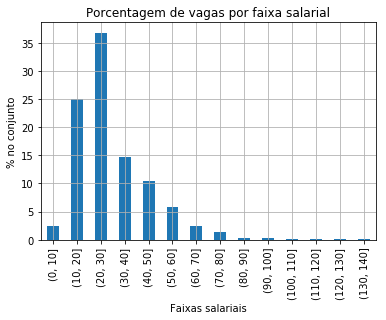

In [37]:
# Remover vagas sem salário e vagas duplicadas
data = data[~pd.isnull(data['numeric_salary'])]
data = data.drop_duplicates()

# Imprimir total de vagas
print "Total de vagas após limpeza e normalização: {}".format(*data.shape)

# Descrever salários
print data['numeric_salary'].describe()

# Imprimir gráfico
ranges = pd.cut(data['numeric_salary'], bins = np.arange(0, 150, 10))
ranges.value_counts(sort = False, normalize = True).mul(100).plot.bar()

plt.ylabel('% no conjunto')
plt.xlabel('Faixas salariais')
plt.title('Porcentagem de vagas por faixa salarial')
plt.grid()

Pelo gráfico, observamos que não existem muitas vagas com salários acima de $70/hora. Vamos remover essas vagas, pois elas podem distorcer nossa medida de erro.

In [38]:
# Remover vagas com salários acima de $70
final_set = data[data['numeric_salary'] <= 70.0]

# Descrever conjunto final de salários
final_set['numeric_salary'].describe()

count    3510.000000
mean       28.975396
std        13.184028
min         5.000000
25%        19.000000
50%        28.200000
75%        36.458333
max        70.000000
Name: numeric_salary, dtype: float64

### 2ª etapa: Representação de valores textuais como vetores numéricos

**TF-IDF com bi-grams**

O primeiro método que iremos explorar para converter informações textuais em vetores é o TF-IDF com bi-grams. Para isso, vamos utilizar a classe `TfidfVectorizer` do sklearn, passando como parâmetro `ngram_range` a tupla (1, 2), indicando que queremos o tratamento de unigrams (palavras únicas) e bigrams (pares de palavras).

Além disso, vamos remover palavras comuns da língua inglesa, passando como parâmetro `stop_words` "english". Isso fará com que os vetores dependam das palavras realmente relevantes nos títulos e descrições das vagas.

In [39]:
# Instanciar vectorizers
title_vectorizer = TfidfVectorizer(ngram_range = (1, 2), stop_words = 'english')
description_vectorizer = TfidfVectorizer(ngram_range = (1, 2), stop_words = 'english')

# Transformar textos em vetores
tf_title = title_vectorizer.fit_transform(final_set['title'])
tf_desc = description_vectorizer.fit_transform(final_set['description'])

**Word2Vec**

O segundo método é o *Word2Vec*. Vamos utilizar o gensim para carregar o modelo já treinado do Google.

Procuraremos as palavras dos títulos e descrições no modelo. Isso nos fornecerá uma lista de vetores. O valor final do título/descrição será simplesmente a média dos vetores encontrados.

In [40]:
# Carregar modelo treinado do Google
w2v_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary = True)

def vectorize_text(text):
    # Obter vetores das palavras contidas no texto, calculando o vetor médio em seguida
    return np.array([w2v_model[word] for word in text if word in w2v_model]).mean(axis = 0)

# Obter vetores de títulos
w2v_title = final_set['title'].str.split()
w2v_title = csr_matrix(w2v_title.apply(vectorize_text).values.tolist())

# Obter vetores de descrições
w2v_desc = final_set['description'].str.split()
w2v_desc = csr_matrix(w2v_desc.apply(vectorize_text).values.tolist())

### 3ª etapa: Validação do modelo

Antes de treinar os modelos, precisamos transformar as outras colunas categóricas em vetores, e agregar todos os vetores em uma única matriz, para que eles possam ser usados pelos modelos.

In [41]:
# Transformar colunas categóricas em vetores
categorical_columns = ['job_type', 'state', 'sec', 'org']
categorical_columns = DictVectorizer().fit_transform(final_set[categorical_columns].to_dict('records'))

# Agregar colunas categóricas e colunas de texto (para TD-IDF e Word2Vec)
tf_features = hstack([tf_title, tf_desc, categorical_columns])
w2v_features = hstack([w2v_title, w2v_desc, categorical_columns])

# Selecionar salários como variável alvo
targets = final_set['numeric_salary']

Vamos separar os conjuntos de treinamento e teste.

In [42]:
# Separar dados de treinamento e teste (TD-IDF)
tf_idf_X_train, tf_idf_X_test, tf_idf_y_train, tf_idf_y_test = train_test_split(tf_features, targets, test_size = 0.20)

# Separar dados de treinamento e teste (Word2Vec)
w2v_X_train, w2v_X_test, w2v_y_train, w2v_y_test = train_test_split(w2v_features, targets, test_size = 0.20)

# Definir variáveis de validação
cv = 5
scoring = 'neg_mean_absolute_error'

**TF-IDF**

Treinaremos e analisaremos três modelos distintos: SVR, KNeighborsRegressor e RandomForestRegressor. Para isso, vamos utilizar o método da validação cruzada.

Ao final, faremos o ajuste do modelo que melhor performar. Usaremos como score final a média de 5 resultados de validação cruzada.

In [43]:
# Treinar SVR
tf_idf_svr = SVR()
tf_idf_svr.fit(tf_idf_X_train, tf_idf_y_train)
tf_idf_svr_score = cross_val_score(tf_idf_svr, tf_idf_X_train, tf_idf_y_train, cv = cv, scoring = scoring)

# Treinar K-nearest neighbors
tf_idf_knn = KNeighborsRegressor()
tf_idf_knn.fit(tf_idf_X_train, tf_idf_y_train)
tf_idf_knn_score = cross_val_score(tf_idf_knn, tf_idf_X_train, tf_idf_y_train, cv = cv, scoring = scoring)

# Treinar Random Forest
tf_idf_rdf = RandomForestRegressor(random_state = 1)
tf_idf_rdf.fit(tf_idf_X_train, tf_idf_y_train)
tf_idf_rdf_score = cross_val_score(tf_idf_rdf, tf_idf_X_train, tf_idf_y_train, cv = cv, scoring = scoring)

# Imprimir scores obtidos
print '(TF-IDF) SVR: ' + str(tf_idf_svr_score.mean())
print '(TF-IDF) KNN: ' + str(tf_idf_knn_score.mean())
print '(TF-IDF) RDF: ' + str(tf_idf_rdf_score.mean())

(TF-IDF) SVR: -9.90694430787
(TF-IDF) KNN: -6.37608855463
(TF-IDF) RDF: -6.11252559394


Observamos que para o método TF-IDF, o melhor resultado foi obtido pelo modelo Random Forest.

**Word2Vec**

Vamos realizar o mesmo procedimento para os dados Word2Vec.

In [44]:
# Treinar SVR
w2v_svr = SVR()
w2v_svr.fit(w2v_X_train, w2v_y_train)
w2v_svr_score = cross_val_score(w2v_svr, w2v_X_train, w2v_y_train, cv = cv, scoring = scoring)

# Treinar K-nearest neighbors
w2v_knn = KNeighborsRegressor()
w2v_knn.fit(w2v_X_train, w2v_y_train)
w2v_knn_score = cross_val_score(w2v_knn, w2v_X_train, w2v_y_train, cv = cv, scoring = scoring)

# Treinar Random Forest
w2v_rdf = RandomForestRegressor(random_state = 1)
w2v_rdf.fit(w2v_X_train, w2v_y_train)
w2v_rdf_score = cross_val_score(w2v_rdf, w2v_X_train, w2v_y_train, cv = cv, scoring = scoring)

# Imprimir scores obtidos
print '(WORD2VEC) SVR: ' + str(w2v_svr_score.mean())
print '(WORD2VEC) KNN: ' + str(w2v_knn_score.mean())
print '(WORD2VEC) RDF: ' + str(w2v_rdf_score.mean())

(WORD2VEC) SVR: -9.73048790187
(WORD2VEC) KNN: -6.47206219323
(WORD2VEC) RDF: -6.46202322367


### 4ª etapa: Ajuste do modelo

**TF-IDF**

Vamos usar o método Grid Search para fazer o ajuste do modelo Random Forest, que melhor performou na etapa de validação.

Vamos variar o parâmetro `min_samples_split` e encontrar o melhor valor.

In [45]:
# Parâmetros a serem variados
tf_idf_parameters = {
  'min_samples_split': [2, 10, 50]
}

# Treinar modelos
tf_idf_regressor = GridSearchCV(RandomForestRegressor(n_estimators = 50, random_state = 1), tf_idf_parameters, scoring = scoring)
tf_idf_regressor.fit(tf_idf_X_train, tf_idf_y_train)

# Imprimir resultados
print 'Melhores parâmetros: ' + str(tf_idf_regressor.best_params_)
print 'Erro absoluto médio de treinamento: ' + str(-tf_idf_regressor.best_score_)
print 'Erro absoluto médio de teste: ' + str(-tf_idf_regressor.score(tf_idf_X_test, tf_idf_y_test))

Melhores parâmetros: {'min_samples_split': 2}
Erro absoluto médio de treinamento: 5.9275679512
Erro absoluto médio de teste: 5.99578893969


**Word2Vec**

Vamos realizar o mesmo procedimento para os dados Word2Vec.

In [46]:
# Parâmetros a serem variados
w2v_parameters = {
  'min_samples_split': [2, 10, 50]
}

# Treinar modelos
w2v_regressor = GridSearchCV(RandomForestRegressor(n_estimators = 50, random_state = 1), w2v_parameters, scoring = scoring)
w2v_regressor.fit(w2v_X_train, w2v_y_train)

# Imprimir resultados
print 'Melhores parâmetros: ' + str(w2v_regressor.best_params_)
print 'Erro absoluto médio de treinamento: ' + str(-w2v_regressor.best_score_)
print 'Erro absoluto médio de teste: ' + str(-w2v_regressor.score(w2v_X_test, w2v_y_test))

Melhores parâmetros: {'min_samples_split': 2}
Erro absoluto médio de treinamento: 6.21289130484
Erro absoluto médio de teste: 6.0761241953


### 5ª etapa: Análise dos resultados

Por fim, vamos analisar o percentual de erro por valor de salário. Para isso, vamos criar um gráfico no qual cada vaga é representada por um ponto. O eixo das abscissas representa o valor real do salário e o eixo das ordenadas representa o percentual de erro da previsão para aquela vaga.

Vamos plotar primeiramente os dados TF-IDF.

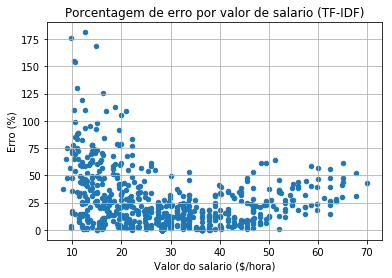

In [47]:
# Predizer salários do conjunto de teste
tf_idf_y_pred = tf_idf_regressor.predict(tf_idf_X_test)

# Calcular percentual de erro relativo ao real valor
tf_idf_y_error = np.divide(np.absolute(np.subtract(tf_idf_y_test.tolist(), tf_idf_y_pred)), tf_idf_y_test.tolist()) * 100

# Plotar resultado
tf_idf_dict = { 'Valor do salário': tf_idf_y_test.tolist(), 'Erro': tf_idf_y_error }
tf_idf_plot = pd.DataFrame(tf_idf_dict)

tf_idf_plot.plot.scatter('Valor do salário', 'Erro')
plt.ylabel('Erro (%)')
plt.xlabel('Valor do salario ($/hora)')
plt.title('Porcentagem de erro por valor de salario (TF-IDF)')
plt.grid()

Faremos o mesmo agora com os dados Word2Vec.

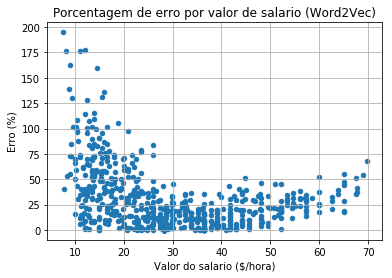

In [48]:
# Predizer salários do conjunto de teste
w2v_y_pred = w2v_regressor.predict(w2v_X_test)

# Calcular percentual de erro relativo ao real valor
w2v_y_error = np.divide(np.absolute(np.subtract(w2v_y_test.tolist(), w2v_y_pred)), w2v_y_test.tolist()) * 100

w2v_dict = { 'Valor do salário': w2v_y_test.tolist(), 'Erro': w2v_y_error }
w2v_plot = pd.DataFrame(w2v_dict)

# Plotar resultado
graph = w2v_plot.plot.scatter('Valor do salário', 'Erro')
plt.ylabel('Erro (%)')
plt.xlabel('Valor do salario ($/hora)')
plt.title('Porcentagem de erro por valor de salario (Word2Vec)')
plt.grid()